<a href="https://colab.research.google.com/github/ugurcancakal/spike_jitter_analysis/blob/master/spike_jitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prerequisites

In [7]:
# @title Import
import numpy as np

# Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

## Either Continuous Spike Time

In [1]:
#@title Data retrieval : Continuous Spike Time 
import os, requests

fname = ['steinmetz_st.npz']

url = ["https://osf.io/4bjns/download"]

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [2]:
#@title Data loading -- Continuous Spike Time
import numpy as np
dat_ST = np.load('steinmetz_st.npz', allow_pickle=True)['dat']

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
dat_ST = dat_ST[11]
print(dat_ST.keys())

dict_keys(['ss', 'ss_passive'])


`dat_LFP`, `dat_WAV`, `dat_ST` contain 39 sessions from 10 mice, data from Steinmetz et al, 2019, supplemental to the main data provided for NMA. Time bins for all measurements are 10ms, starting 500ms before stimulus onset (same as the main data). The followin fields are available in dat. 

* `dat['ss']`: neurons by trials. Exact spikes times for each neuron and each trial, reference to the stimulus onset. A (neuron,trial) entry can be an empty list if that neuron did not fire at all on that trial. 
* `dat['%X%_passive']`: same as above for `X` = {`lfp`, `ss`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 




## Or Raw Spike Data

In [10]:
#@title Data retrieval -- Raw Spike
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


In [11]:
#@title Data loading -- Raw Spike
import numpy as np

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
dat = alldat[11]
print(dat.keys())

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned). 

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron. 
* `dat['ccf_axes']`: axes names for the Allen CCF. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_times']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera. 
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time. 
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  




# Function Implementations

In [16]:
def spike_jitter(refrerence, target, synch_width):
  '''Compute the number of spikes within the [-w,w] interval

    Args:
      reference(1D float array): exact spike times of the reference neuron
      target(1D float array): exact spike times of the target neuron
      synch_width (int): absolute value of w in miliseconds to construct [-w,w]

    Returns:
      number of spikes (int): Number of spikes within the synch_width 

    NOTES:
    * For now, the interval has thought to be symmetric with respect to origin 
      but in case it's desired, it could be modified to support [lower, upper] 
      definition.
    
    * The shapes of the reference and target neuron recordings does not need to 
      match. If it creates problems, instead of using 1D float arrays, there is 
      a chance to use the raw spike recording which are 1D boolean arrays 
      guaranteed to have the same shape.
    @ugurc
  '''

In [14]:
def synchrony_analysis(region, synch_width):
  '''Analyse the synchrony between the neurons in a given region

    Args:
      region(1D array of numpy arrays): array of numpy arrays consisting of spike 
        time arrays of neurons in a given region.
      synch_width (int): absolute value of w in miliseconds to construct [-w,w]

    Returns:
      num_spikes(2D matrix): a matrix consisting of respective spike
        times between two neurons [target][reference]
    
    NOTES:
      * In the region structure, numpy arrays might have different shapes.

      * If it's hard to deal with sparse spike time, instead of using 1D float 
        arrays, there is a chance to use the raw spike recording which are 1D 
        boolean arrays guaranteed to have the same shape.

      * If width has chosen to be symmetric([w-,w]), there is no need to keep 
        track of [target][reference] and [reference][target] cells separately.
        Also, there is no need to analyze if the neuron has a correspondence 
        with itself. It eliminates the need for diagonal entries like ([1][1]). 
        Therefore, the num_spikes matrix has implemented as an upper diagonal 
        matrix. If we would like to keep track of succeeding and preceding 
        neurons information, [0,w_positive] and [w_negative,0] intervals need to 
        be analyzed separately. In that case, instead of an upper triangular 
        matrix, we would need to generate two full matrices. One for 
        [0,w_positive] interval and one for [w_negative,0] interval.
    @ugurc
  '''
  breath = len(range)
  num_spikes = np.zeros((breath,breath))

  for i in range(breath):
    for j in range(i+1, breath):
      num_spikes[i][j] = spike_jitter(range[i], range[j], synch_width)


In [19]:
def raster_plot(spike_times, neurons_of_interest):
  '''Creates a raster plot of given spike times and neruons of interest

  Args:
    spike_times(1D array of numpy arrays): array of numpy arrays consisting of 
      spike time arrays of neurons.
    neurons_of_interest(1D array): an array of neuron indexes to be presented 
      in the raster plot
  @ugurc
  '''

  plt.eventplot(spike_times[neuron_idx], color=".2")
  plt.xlabel("Time (s)")
  plt.show()

# Tests

In [17]:
# @title Generating Upper Triangular Matrix
import numpy as np
test = np.zeros((10,10))
for i in range(10):
  for j in range(i+1, 10):
    test[i][j] = 1

print(test)

[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


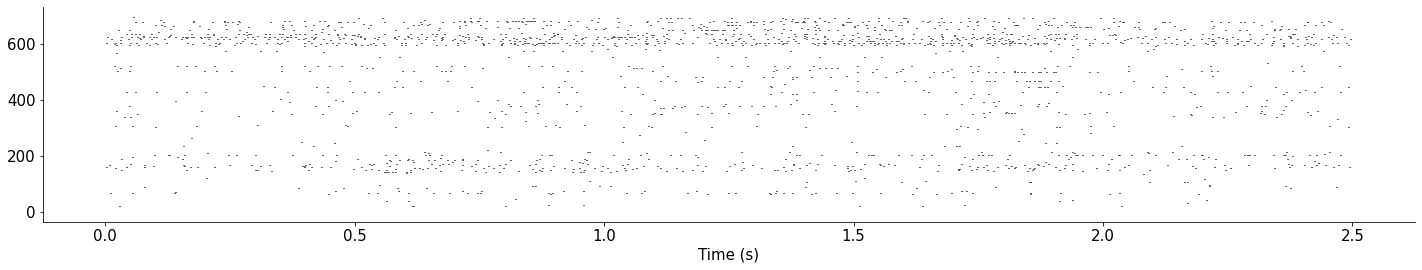

In [20]:
# @title Raster Plot
# !!! Retrieve and load the continuous spike time data first

neuron_idx = np.arange(0, len(dat_ST['ss'][:,50]), 1)
# neuron_idx = 87
raster_plot(dat_ST['ss'][:,50], neuron_idx)